In [2]:
# import geemap
from IPython.display import Image 
import shutil
import requests
import ee 
import rasterio
from pylab import plt
import rasterio.features
import rasterio.warp
import numpy as np
import json
from retry import retry
import glob
import ee_helper as eeh
# " !pip install earthengine-api --upgrade

In [3]:
SIZE = 256

# SPECIES_NAME = 'Ursus_arctos_Linnaeus'
# SPECIES_NAME = 'Theropithecus_gelada'
SPECIES_NAME = 'Yucca_brevifolia'
# SPECIES_NAME = 'Camel'
path = f'../../data/gee/{SPECIES_NAME}'
tif_path = f'../../data/sdm/{SPECIES_NAME}_prediction'
eeo = eeh.EEH(path +'/' +str(SIZE), size = SIZE)
eeo.meters = 13000

## LOAD SDM

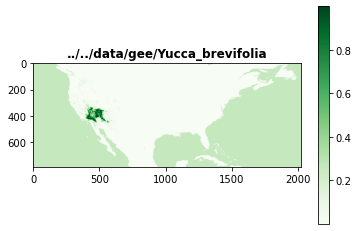

In [4]:
src = rasterio.open( tif_path+"/RF-IMAGES/probability_1.0.tif")
distr_rf = rasterio.open(tif_path + "/RF-IMAGES/probability_1.0.tif").read(1)
distr_et = rasterio.open(tif_path + "/ET-IMAGES/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open(tif_path + "/XGB-IMAGES/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open(tif_path + "/LGBM-IMAGES/probability_1.0.tif").read(1)
src_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4

def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap)
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

plotit(src_averaged, path, cmap="Greens")

In [5]:
items = eeh.getPoints(path +'/' +str(SIZE) +'/' + SPECIES_NAME+ '.json', src_averaged, src, 0.80)
indexes = [i for i in range(len(items))]
print(len(indexes))
save_path = []*len(indexes)
parm = zip(indexes, items)

tif size: 2026 x 787
5304
5304


## GET RGB, DEM

In [8]:
eeo.workALOS(indexes, items)

In [9]:
eeo.workSAT(indexes, items)

## to RGBA

In [ ]:
import image_process as ip

# name = 'Ursus_arctos_Linnaeus'
# name = 'Theropithecus_gelada'
# name = "Camel"
name = 'Yucca_brevifolia'
path = f'data/{name}/256'
sat_files = f'{path}/sat/*.png'
dem_files = f'{path}/alos/*.png'
json_path = f'{path}/{name}.json'

image_process = ip.ImageProcess(json_path=json_path, 
                                save_path=f'{path}/rgbaa', 
                                rgb_path=sat_files,
                                 gray_path=dem_files)
# image_process.black_threshold = 2
# image_process.sum_threshold = 5000
image_process.start_merge_without_sea()

## TEST

In [14]:

RGB = ['B4', 'B3', 'B2']
TRUE_RGB = ['TCI_R', 'TCI_G', 'TCI_B']

# idx =293
# idx = 833
# idx = 1008
# idx = 1123
idx = 1319
# idx  = 1512 # cloud
# idx = 698
# idx = 1164
# idx = 1462
# idx = 1558
# idx = 1577
# idx = 1619
# idx = 1669
# idx = 1824
# idx = 4032
# idx = 4218
# idx = 4345
# idx = 4385
# idx = 4479
# idx = 4641
# idx = 4643
# idx = 4645
# idx = 4651
# idx = 4654
# idx = 4772
# idx = 4875   # cloud 8
# idx = 4987
# idx = 5134
# idx = 5147
# idx = 5184

# idx = 5202   # cloud 8 10
idx = 5# cloud
# idx = 5214 # cloud
# idx = 5179
# idx= 5202

u_lon = items[idx][0]
u_lat = items[idx][1]
print(u_lon, u_lat)
u_poi = ee.Geometry.Point(u_lon, u_lat)
lyon = u_poi.buffer(13000)  # meters
image= (ee.ImageCollection("COPERNICUS/S2_SR")
                    .filterBounds(lyon.bounds())  
                    # .filterDate('2019-11-15', '2019-12-15')

                     .filter(ee.Filter.calendarRange(2017, 2019,  'year'))
                    .filter(ee.Filter.calendarRange(6, 10, 'month'))
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',15))
                    .select(RGB)                        
                    .median()
                    )
minn = 0     # math.floor( np.amax(np.array(mymin)))
maxx = 4000  #


url = image.getThumbURL({
              'bands': RGB,
              'min': [minn, minn, minn], 
              'max': [maxx, maxx, maxx],
              'gamma': 1    ,
              'region': lyon.bounds(),
              'crs': 'EPSG:4326',
              'dimensions': [512, 512],
              'bestEffort': True,
              'format': 'png'})

r = requests.get(url, stream=True)
if r.status_code != 200:
    print("failed to download")

filename = "tmp.png"
with open(filename, "wb") as out_file:
    shutil.copyfileobj(r.raw, out_file)
Image(url=url)

13.812500000000023 65.06250000000007
